<a href="https://colab.research.google.com/github/gw456/COUGH-C19/blob/main/Bangkit_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD DATASET DI GITHUB

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

EKSTRAK DATA WAV DAB JSON DI FOLDER COSWARA

In [ ]:
import os
import sys
import subprocess
import numpy as np
import glob
import json
import pandas as pd
import json
import csv

In [ ]:
'''
This script creates a folder "Extracted_data" inside which it extracts all the wav files in the directories date-wise
'''

coswara_data_dir = '/content/Coswara-Data' # Local Path of iiscleap/Coswara-Data Repo
extracted_data_dir = os.path.join(coswara_data_dir, 'Extracted_data')  

if not os.path.exists(coswara_data_dir):
    raise("Check the Coswara dataset directory!")

if not os.path.exists(extracted_data_dir):
    os.makedirs(extracted_data_dir) # Creates the Extracted_data folder if it doesn't exist

dirs_extracted = set(map(os.path.basename,glob.glob('{}/202*'.format(extracted_data_dir))))
dirs_all = set(map(os.path.basename,glob.glob('{}/202*'.format(coswara_data_dir))))

dirs_to_extract = list(set(dirs_all) - dirs_extracted)

print(dirs_to_extract)

for d in dirs_to_extract:
    p = subprocess.Popen('cat {}/{}/*.tar.gz.* |tar -xvz -C {}/'.format(coswara_data_dir, d, extracted_data_dir), shell=True)
    p.wait()


print("Extraction process complete!")

TypeError: ignored

MEMILIH FILE COUGH-HEAVY.WAV DENGAN KOMORBID BATUK

Menyiapkan directory yang akan dipindah

In [ ]:
def menyiapkan_directory_pindahan():
  coughHeavy_wavfile_dir = os.path.join('/content', 'Cough-Heavy_wavfile')

  if not os.path.exists(extracted_data_dir):
      raise("Check the Coswara dataset directory!")

  if not os.path.exists(coughHeavy_wavfile_dir):
      os.makedirs(coughHeavy_wavfile_dir)

  dirs_metadata_json = list(map(os.path.abspath, glob.glob('{}/202*/**/metadata.json'.format(extracted_data_dir), 
                                                           recursive = True)))
  dirs_metadata_json = sorted(dirs_metadata_json)

  dirs_cough_heavy_wav = list(map(os.path.abspath, glob.glob('{}/202*/**/cough-heavy.wav'.format(extracted_data_dir), 
                                                           recursive = True)))
  dirs_cough_heavy_wav = sorted(dirs_cough_heavy_wav)

  print(len(dirs_metadata_json))
  print(len(dirs_cough_heavy_wav))

  for i in range(600,607):
    print(dirs_metadata_json[i])
    print(dirs_cough_heavy_wav[i])

  return dirs_metadata_json, dirs_cough_heavy_wav, coughHeavy_wavfile_dir

dirs_metadata_json, dirs_cough_heavy_wav, coughHeavy_wavfile_dir =menyiapkan_directory_pindahan()

TypeError: ignored

In [ ]:
#Hapus metadata dalam sub folder, sehingga jumlah data sama
!rm /content/Coswara-Data/Extracted_data/20200418/0VpjgRGE5kR8uTEhksBgvFR3xlA2/0VpjgRGE5kR8uTEhksBgvFR3xlA2/metadata.json
!rm /content/Coswara-Data/Extracted_data/20200418/19VBCVaFPcWROz6wWui9G9IU9K12/19VBCVaFPcWROz6wWui9G9IU9K12/metadata.json
!rm /content/Coswara-Data/Extracted_data/20200418/22oBvWaWwBhbdNfWoshbse1qZ4q2/22oBvWaWwBhbdNfWoshbse1qZ4q2/metadata.json

dirs_metadata_json, dirs_cough_heavy_wav, coughHeavy_wavfile_dir =menyiapkan_directory_pindahan()

rm: cannot remove '/content/Coswara-Data/Extracted_data/20200418/0VpjgRGE5kR8uTEhksBgvFR3xlA2/0VpjgRGE5kR8uTEhksBgvFR3xlA2/metadata.json': No such file or directory
rm: cannot remove '/content/Coswara-Data/Extracted_data/20200418/19VBCVaFPcWROz6wWui9G9IU9K12/19VBCVaFPcWROz6wWui9G9IU9K12/metadata.json': No such file or directory
rm: cannot remove '/content/Coswara-Data/Extracted_data/20200418/22oBvWaWwBhbdNfWoshbse1qZ4q2/22oBvWaWwBhbdNfWoshbse1qZ4q2/metadata.json': No such file or directory


TypeError: ignored

Memindah directory yang mengandung komorbid batuk

In [ ]:
with open('index_dan_label_data.csv', mode = 'w') as file:
  data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
  data_writer.writerow(['Index', 'Label'])
  for i in range(0, len(dirs_metadata_json)):
    f = open(dirs_metadata_json[i])
    dictionary = json.load(f)
    if "cough" in dictionary:
      if dictionary["covid_status"] in ['positive_moderate', 'positive_mild', 'positive_asymp']:
        data_writer.writerow([i, 1])
      else:
        data_writer.writerow([i, 0])
      f.close()
      p = subprocess.Popen('mv {} {}/{}.wav'.format(dirs_cough_heavy_wav[i], 
                                                  coughHeavy_wavfile_dir, i+1), 
                                                  shell=True)
      p.wait()
    else:
      f.close()

print("Data movement process complete!")

NameError: ignored

PRE-PROCESSING

pre-processing yang dilakukan adalah mengubah wav data menjadi time series data, lalu memotongnya menjadi beberapa periode batuk yang dikandung masing-masing data.

MENGKONVERSI KE TIME SERIES DATA

Definisi Fungsi

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [ ]:
def konversi_time_series(file_dir):
  data, fs = sf.read(file_dir) 
  T = 1/fs
  t = [k*T for k in range(len(data))]
  return data, t

def plot_data_time_series(data, t):
  list_data = []
  for row in data:
    list_data.append(row) 
  plt.plot(t,list_data)
  plt.show()

def plot_data_csv(filename):
  df = pd.read_csv(filename)
  fig = go.Figure(go.Scatter(x = df['Waktu'], y = df['Data']))
  fig.update_layout(title='Cough Time Series',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True)
  fig.show()

Konversi wav file ke time series data

In [ ]:
panjang_baru = os.listdir('/content/Cough-Heavy_wavfile')
print(len(panjang_baru))

coughHeavy_csvfile_dir = os.path.join('/content', 'Cough-Heavy_csvfile')

if not os.path.exists(coughHeavy_wavfile_dir):
    raise("Check the your directory!")

if not os.path.exists(coughHeavy_csvfile_dir):
    os.makedirs(coughHeavy_csvfile_dir)
    with open('/content/index_dan_label_data.csv') as data_baca:
      data_reader = csv.reader(data_baca, delimiter=',')
      line_count = 0
      for row in data_reader:
        if line_count == 0:
            line_count += 1
        else:
            index = str(int(row[0])+1)
            data_raw = open('{}/data_raw_wav_{}.csv'.format(coughHeavy_csvfile_dir, index), mode = 'w')
            data_writer = csv.writer(data_raw, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
            data_writer.writerow(['Waktu', 'Data'])
            file_dikonversi = '{}/{}.wav'.format(coughHeavy_wavfile_dir, index)
            bacaan, waktu = konversi_time_series(file_dikonversi)
            for i in range(len(bacaan)):
              data_writer.writerow([waktu[i], bacaan[i]])
            data_raw.close()
            line_count += 1
        
print("Time series data accuired!")

Tes Keberhasilan konversi

In [ ]:
panjang_wav = len(os.listdir('/content/Cough-Heavy_wavfile'))
panjang_csv = len(os.listdir('/content/Cough-Heavy_csvfile'))
print(panjang_wav == panjang_csv)
 
file_dir = '/content/Cough-Heavy_wavfile/1106.wav'
data_1, t_1 = konversi_time_series(file_dir)
plot_data_time_series(data_1, t_1)
 
raw_dir = '/content/Cough-Heavy_csvfile/data_raw_wav_1106.csv'
plot_data_csv(raw_dir)

EKSTRAKSI FITUR STATISTIK

In [ ]:
from scipy.linalg import svd
import statistics as stat
import math

In [ ]:
def ekstraksi_fitur_stat(data):
  #Reshape np.array into 2 dimension
  number = len(data)
  factors = []
 
  for whole_number in range(1, number + 1):
    if number % whole_number == 0:
      factors.append(whole_number)
 
  if len(factors)%2 == 0:
    index = (len(factors)//2)-1
    M = factors[index]
    N = factors[index+1]
  else:
    index = (len(factors)-1)//2
    M = factors[index]
    N = M
  data_reshape = data.reshape((N,M))
 
  #Calculating Singular Value Decomposition and statistics parameter
  U, S, V = svd(data_reshape)
  column = np.shape(S)[0]
  sum = 0
  list_S = []
  for row in range (column):
    list_S.append(S[row])
    sum = sum + S[row]
 
  std = 0
  average = sum/column
  for i in range(column-1):
    std = std + (list_S[i]-average)**2
  std = math.sqrt(std/(column-1))
  med = stat.median(list_S)
  max = np.amax(list_S)
  min = np.amin(list_S)
  return average, std, med, max, min

In [ ]:
#Mencari file kosong
file_kosong = []
path = '/content/Cough-Heavy_csvfile'
for files in os.listdir(path):
  df = pd.read_csv('{}/{}'.format(path, files))
  if df.empty == True:
    file_kosong.append(files)
print(file_kosong)

In [ ]:
path_cough_csv = '/content/Cough-Heavy_csvfile'

with open("/content/Hasil_Fitur_Statistik.csv", 'w') as file:
  write = csv.writer(file, delimiter=',')
  #write.writerow(['filename', 'Mean', 'std', 'median', 'max', 'min', 'label'])
  for files in os.listdir(path_cough_csv):
    print(files)
    if files not in file_kosong:
      #Mengekstraksi fitur statistik
      data_list = list()
      line_count = 1
      for row in open('{}/{}'.format(path_cough_csv, files), 'r'):
        if line_count == 1:
          line_count += 1
        else:
          data_list.append(row[1])
      data = np.array(data_list)
      average, std, med, max, min = ekstraksi_fitur_stat(data)

      #Menyiapkan labelnya
      label = open("/content/index_dan_label_data.csv", 'r')
      label_data = csv.reader(label, delimiter = ',')
      baris_count = 1
      for baris in label_data:
        if baris_count == 1:
          baris_count += 1
        else:
          baris_count += 1
          index = str(int(baris[0])+1)
          file_bandingan = 'data_raw_wav_{}.csv'.format(index)
          if files == file_bandingan:
            labels = baris[1]
            print(file_bandingan, labels)
            break
      label.close()

      #Memasukkan data ke csv
      write.writerow([files, average, std, med, max, min, labels])

print("Ekstraksi feature selesai")

MENYIAPKAN DATA LATIH DAN DATA UJI

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.preprocessing import MinMaxScaler
import sklearn

In [ ]:
data_stat = pd.read_csv('/content/Hasil_Fitur_Statistik.csv',
                        names = ['Mean', 'std', 'median', 'max', 'min', 'label'])
print(data_stat['Mean'].iloc[0])
data_stat.head()

3.6369964243766457


,Mean,std,median,max,min,label
data_raw_wav_1408.csv,3.636996,85.551140,2.049574e-13,2053.150266,1.223873e-13,1
data_raw_wav_1548.csv,3.047451,67.033242,1.513853e-13,1516.702319,4.352928e-14,0
data_raw_wav_1411.csv,2.027215,33.679648,5.856276e-14,587.102274,1.699418e-14,1
data_raw_wav_1409.csv,3.496532,77.005301,1.739075e-13,1742.339668,4.313570e-14,1
data_raw_wav_1448.csv,2.559819,46.903433,8.975397e-14,899.640161,1.564129e-14,0


In [ ]:
data_stat_feature = data_stat.copy()
data_stat_label = data_stat_feature.pop('label')

x_train, x_test, y_train, y_test = train_test_split(data_stat_feature, data_stat_label, test_size=0.2)

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

def scaleData(data):       
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

x_train = scaleData(x_train)
x_test = scaleData(x_test)

GENERATE MODEL

In [ ]:
import pathlib

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
         def on_epoch_end(self, epoch, logs={}):# Your Code
            if(logs.get('accuracy')>0.64):
                print('\nReached 64% accuracy so cancelling training!')
                self.model.stop_training = True
 
callbacks = myCallback()

In [ ]:
model_stat = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape = [5]),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model_stat.summary()

model_stat.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.002), metrics = ['accuracy'])
history = model_stat.fit(x_train, y_train, epochs = 100, callbacks=[callbacks], validation_data=(x_test, y_test))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_104 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_105 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_106 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_107 (Dense)            (None, 16)                2064      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 17        
Total params: 52,385
Trainable params: 52,385
Non-trainable params: 0
_________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


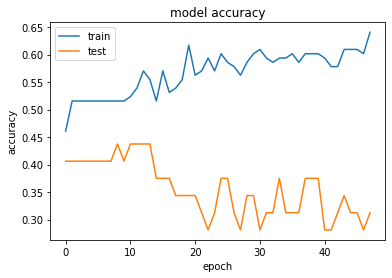

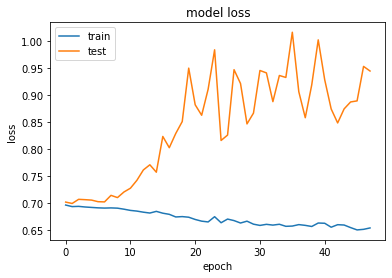

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

SAVE MODEL

In [ ]:
export_dir = '/content'
tf.saved_model.save(model_stat, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/assets


In [ ]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

59344

COBA-COBA

In [ ]:
df = pd.read_csv('/content/Cough-Heavy_csvfile/data_raw_wav_1662.csv')
print(df)
print(df.shape)
print(df.shape[0] == 0)
last_element = df['Waktu'].iloc[-1]
print(last_element)

In [ ]:
df = pd.read_csv('{}/{}'.format(path, 'data_raw_wav_1662.csv'))
before_last_element = df['Waktu'].iloc[-2]
last_element = df['Waktu'].iloc[-1]
beda_optimal = 18 - last_element
beda_iterasi = last_element - before_last_element

print(beda_optimal, beda_iterasi, last_element, before_last_element)

6.8213541666666675 2.083333333224857e-05 11.178645833333333 11.178625


MENYAMAKAN PANJANG DATA

In [ ]:
#Mencari panjang data terpanjang dan file kosong
max_length = 0
file_kosong = []
path = '/content/Cough-Heavy_csvfile'
for files in os.listdir(path):
  df = pd.read_csv('{}/{}'.format(path, files))
  if df.empty == True:
    file_kosong.append(files)
  else:
    last_element = df['Waktu'].iloc[-1]
    if max_length < last_element:
      max_length = last_element
      print(files)
print(max_length)
print(file_kosong) #Abaikan file kosong (776, 1546, 991) saat training, evaluasi, dan validasi

In [ ]:
#Membuat semua panjang data csv menjadi 18 detik
for files in os.listdir(path):
  df = pd.read_csv('{}/{}'.format(path, files))
  last_element = df['Waktu'].iloc[-1]
  if last_element < max_length:
    beda = max_length - last_element
